Our main goal is to be able to represent loaded music. We will use FFT for that.
What are the needs?
We're creating a video, let's say, 5 mins long, of 60fps. That means, we have 18.000 video frames in total.
If the incoming audio is of 44.100 sample rate, for each video frame we have 735 samples, so that would be our window for FFT analysis.

But, there's another thing to consider. The resulting texture.
Should it be updated each frame and contain only that window? Time consuming, we could fall off off being real time.
Or maybe we should prepare one texture of the whole song, where on Y axis it'd have FFT for a single frame, and frames would be put on X axis? Tat would be best, BUT - in case of our sampe 5mins long video it'd mean 18K length, that's not an option to load up as a texture into OpenGL...

In [16]:
from scipy.io import wavfile as wav
from scipy.fftpack import fft, fftfreq
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from matplotlib import colors as clrs
from skimage.transform import resize
from skimage import exposure
from scipy.signal import ShortTimeFFT
from scipy.signal.windows import gaussian

Ok, let's load some music

In [6]:
filename = 'test_sound_01.wav'
sample_rate, audio = wav.read(filename)
if audio.ndim > 1:
    audio = np.mean(audio, axis=1)
num_samples = audio.shape[0]
length = num_samples / sample_rate
max_sample_value = np.max(audio)

print(f'Audio sample rate: {sample_rate}, number of samples: {num_samples}. Length: {length}, max sample value is: {max_sample_value}')

Audio sample rate: 44100, number of samples: 2525915. Length: 57.276984126984125, max sample value is: 28399.0


Lets draw samples:

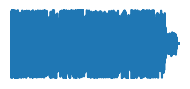

In [8]:
fig = plt.figure(figsize=(2.0,1.0), dpi=100)
canvas = FigureCanvas(fig)
ax = plt.axes()
ax.set_axis_off()
ax.margins(0)
ax.plot(np.arange(num_samples) / sample_rate, audio)
fig.tight_layout()
canvas.draw()


dd

In [41]:
plt.close(fig)
framerate = 30.0
position = 5.0
number_of_frames = 1 # how many video frames to analyze

total_frames = int(length * framerate)
current_frame = int(position*framerate)
sample_start = int((current_frame) / framerate * sample_rate)
sample_end = int((current_frame + number_of_frames) / framerate * sample_rate)
N = sample_end - sample_start
T = 1.0 / sample_rate
audio_part = audio[sample_start:sample_end]

print(f'Current video frame: {current_frame}/{total_frames}')
print(f'Number of audio samples to analyze: {N}')


Current video frame: 150/1718
Number of audio samples to analyze: 1470


In [36]:
# prepare a colormap
reds = plt.get_cmap('Reds', 256)
black_reds = reds(np.linspace(0, 1, 256))
for i in range(256):
    black_reds[i:i+1, :] = np.array([i/256, 0, 0, 1])
map_black_reds = clrs.ListedColormap(black_reds)
colormap = map_black_reds

Number of freqs: 1470


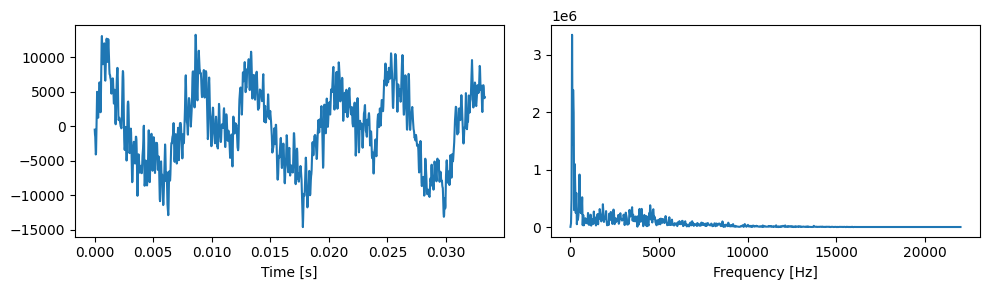

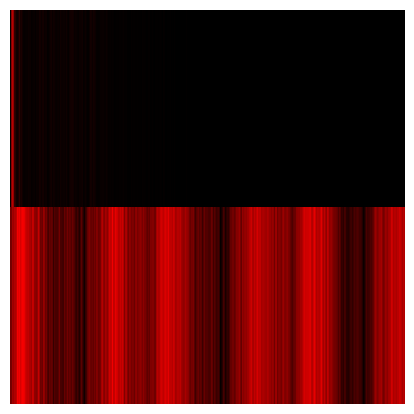

In [42]:
freqs = fftfreq(N, T)
print(f'Number of freqs: {freqs.size}')
spectrum = abs(fft(audio_part))[:int(freqs.size/2)]

fig=plt.figure(figsize=(10, 3))
axes=[]
axes.append(fig.add_subplot(1, 2, (1, 1)))
axes.append(fig.add_subplot(1, 2, (2, 2)))

axes[0].plot(np.arange(N) / sample_rate, audio_part)
axes[0].set_xlabel('Time [s]')
axes[1].plot(freqs[:int(freqs.size/2)], spectrum)
axes[1].set_xlabel('Frequency [Hz]')

fig.tight_layout()    
plt.show()
plt.close(fig)

audio_part_img = exposure.rescale_intensity(audio_part, out_range=(-1.0, 1.0))
audio_part_img = np.expand_dims(audio_part_img, axis=0)
audio_part_img = resize(audio_part_img, (256, 512), anti_aliasing=True)

spectrum_img = exposure.rescale_intensity(spectrum, out_range=(0, 100))
spectrum_img = np.expand_dims(spectrum_img, axis=0)
spectrum_img = resize(spectrum_img, (256, 512), anti_aliasing=True)

fig=plt.figure(figsize=(5.12, 5.12), dpi=100)
fig.subplots_adjust(hspace=0)
fig.tight_layout()
axes=[]
axes.append(fig.add_subplot(2, 1, 1))
axes[0].set_axis_off()
axes[0].margins(0)
axes.append(fig.add_subplot(2, 1, 2))
axes[1].set_axis_off()
axes[1].margins(0)

axes[0].imshow(spectrum_img, cmap=map_black_reds)
axes[1].imshow(audio_part_img, cmap=map_black_reds)

plt.savefig("test_sound.png", dpi=fig.dpi)
plt.show()
plt.close(fig)